**RMSD & Q Plots**

This notebook generates RMSD (Root Mean Squared Deviation) vs Q (Percent Native Contacts) plots to compare two trajectories. Both plots are generated based on carbon alphas (CAs) only.

RMSD represents how much the distance between each pair of CAs has changed from the "native" conformation. 

"Native contacts" are all the CA pairs closer than some arbitrary distance in the native conformation, and the Q value for a frame is the percentage of these that are still within that cutoff distance.

Reference: https://userguide.mdanalysis.org/1.1.1/examples/analysis/distances_and_contacts/contacts_native_fraction.html

In [1]:
import os
import glob
import mdtraj
from matplotlib import pyplot as plt
from matplotlib import colormaps

import itertools
import numpy as np

In [2]:
def calculate_q_rmsd(native, sim_traj, target_frame_count=None):
    # https://userguide.mdanalysis.org/1.1.1/examples/analysis/distances_and_contacts/contacts_native_fraction.html

    if isinstance(native, str):
        native_traj = mdtraj.load_frame(native, 0)
    else:
        native_traj = native[0]

    ca_atoms = native_traj.topology.select("name CA")
    all_ca_pairs = np.array([i for i in itertools.product(ca_atoms, ca_atoms) if i[0] != i[1]])
    native_dist = mdtraj.compute_distances(native_traj[0], all_ca_pairs)[0]

    if isinstance(sim_traj, str):
        sim_traj = mdtraj.load(sim_traj)
        if target_frame_count:
            sim_traj = sim_traj[::max(1,len(sim_traj)//target_frame_count)]

    ca_atoms = sim_traj.topology.select("name CA")
    all_ca_pairs = np.array([i for i in itertools.product(ca_atoms, ca_atoms) if i[0] != i[1]])

    # native_dist = mdtraj.compute_distances(sim_traj[0], all_ca_pairs)[0]
    # print(len(all_ca_pairs), len(native_dist))
    native_pairs = all_ca_pairs[native_dist < 0.8]
    print("pairs:", len(all_ca_pairs), "native:", len(native_pairs))

    percent_native = np.sum(mdtraj.compute_distances(sim_traj, native_pairs)<0.8,axis=1)/len(native_pairs)
    rmsd_values = mdtraj.rmsd(sim_traj, native_traj, atom_indices=ca_atoms)
    return(percent_native, rmsd_values)

In [3]:
def make_plot_grid(length, row_len=3):
    fig, axes = plt.subplots((length+row_len-1)//row_len, min(row_len, length))
    # Ensure axes is always a 2d array
    if isinstance(axes, plt.Axes):
        axes = np.array([[axes]])
    elif len(axes.shape) == 1:
        axes = axes[np.newaxis, :]
    for i in range(length,len(axes.flat)):
        axes.flat[i].remove()
    fig.set_figheight(6*len(axes))
    fig.set_figwidth(6*len(axes[0]))
    return fig, axes

In [ ]:
coordinate_files = [
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/cg_Majewski_prior_2024.07.06/6MRR/raw/coordinates.npy",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_Majewski_prior_2024.07.06_SiLU__wd0_lr2.5en4__6MRR_*.h5",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_2024.06.26_400fs_CA_lj_angle_SiLU__wd0_lr2.5en4__6MRR_*.h5",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_Majewski_prior_2024.08.03_constrain_SiLU_cutoff2__wd0_lr2.5en4__smax128__6MRR_*.h5",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_Majewski_prior_2024.08.03_constrain_tag_SiLU_cutoff2__wd0_explr1en3_0.85__smax128__6MRR_*.h5",
]

# Select another protein from the same set of models
#coordinate_files = [i.replace("6MRR", "3ID4") for i in coordinate_files]
coordinate_files = [i.replace("6MRR", "2VQ4") for i in coordinate_files]

coordinate_list = []
label_list = []
subtraj_lengths_list = []

for cf in coordinate_files:
    label_list.append(os.path.basename(cf))
    batch_traj = []
    # batch_tags = []
    subtraj_lengths = []
    for subtraj in glob.glob(cf):
        if subtraj.endswith("npy"):
            coords = np.load(subtraj)
            # Select with a stride that brings the total down to ~10,000
            if len(coords > 10000):
                coords = coords[::(len(coords)//10000)]
            # Convert to NM to match mdtraj coordinates
            coords = coords/10
            psf_path = glob.glob(os.path.join(os.path.dirname(cf),"../processed/*_processed.psf"))[0]
            traj = mdtraj.Trajectory(coords, topology=mdtraj.formats.psf.load_psf(psf_path))
        else:
            traj = mdtraj.load(subtraj)
        batch_traj.append(traj)
        # batch_tags.append(np.repeat(len(batch_tags)+1, len(traj)))
        subtraj_lengths.append(len(traj))
    if len(batch_traj) == 0:
        print("Failed to load:", cf)
    coordinate_list.append(mdtraj.join(batch_traj))
    # traj_tags_list.append(np.concatenate(batch_tags))
    subtraj_lengths_list.append(subtraj_lengths)

assert len(coordinate_list) == len(label_list)
print(coordinate_list)

In [ ]:
traj_values = [calculate_q_rmsd(coordinate_list[0][0], i, target_frame_count=10000) for i in coordinate_list]

In [ ]:
fig, axes = make_plot_grid(len(traj_values))
fig.suptitle('Percent Native')

y_min = np.min([np.min(tv[0]) for tv in traj_values])
for ax, tv, label, subtraj_lengths in zip(axes.flat, traj_values, label_list, subtraj_lengths_list):
    ax.set_title(label)
    x = range(len(tv[0]))
    start = 0
    for i in subtraj_lengths:
        ax.plot(x[start:start+i], tv[0][start:start+i])
        start += i
    ax.set_ylim(y_min, 1.0)
fig.set_tight_layout(True)
pass

In [ ]:
fig, axes = make_plot_grid(len(traj_values))
fig.suptitle('RMSD')
y_max = np.max([np.max(tv[1]) for tv in traj_values])
for ax, tv, label, subtraj_lengths in zip(axes.flat, traj_values, label_list, subtraj_lengths_list):
    ax.set_title(label)
    # ax.plot(range(len(tv[1])), tv[1])
    x = range(len(tv[1]))
    start = 0
    for i in subtraj_lengths:
        ax.plot(x[start:start+i], tv[1][start:start+i])
        start += i
    ax.set_ylim(0, y_max)
fig.set_tight_layout(True)
pass

In [8]:
def calc_rmsd_plot_bounds(traj, other_bounds=None):
    axis_xmin = np.min(traj[0])*0.9
    axis_xmax = np.max(traj[0])*1.1
    axis_ymin = np.min(traj[1])*0.9
    axis_ymax = np.max(traj[1])*1.1
    if other_bounds:
        axis_xmin = min(axis_xmin, other_bounds[0][0])
        axis_xmax = max(axis_xmax, other_bounds[0][1])
        axis_ymin = min(axis_ymin, other_bounds[1][0])
        axis_ymax = max(axis_ymax, other_bounds[1][1])

    return ((axis_xmin, axis_xmax), (axis_ymin, axis_ymax))

In [ ]:
fig, axes = make_plot_grid(len(traj_values))
fig.suptitle('RMSD vs Q')

traj_bounds = calc_rmsd_plot_bounds(traj_values[0])
for tv in traj_values[1:]:
    traj_bounds = calc_rmsd_plot_bounds(tv, traj_bounds)

# base_traj_bounds = calc_rmsd_plot_bounds(traj_values[0])

for ax, tv, label, subtraj_lengths in zip(axes.flat, traj_values, label_list, subtraj_lengths_list):
    # traj_bounds = calc_rmsd_plot_bounds(tv, base_traj_bounds)
    ax.set_title(label)

    ax.set_xlabel("% native contacts")
    ax.set_ylabel("RMSD (nm)")

    ax.set_xlim(*traj_bounds[0])
    ax.set_ylim(*traj_bounds[1])

    plot_colors = np.concatenate([np.repeat(i, j) for i,j in enumerate(subtraj_lengths)])
    ax.scatter(traj_values[0][0], traj_values[0][1], color="red", s=2, label="Ref")
    ax.scatter(tv[0], tv[1], c=plot_colors, cmap="winter", s=2, label="Traj")
    ax.legend()

fig.set_tight_layout(True)
pass

In [10]:
def contact_map(sim_traj,inthresholds = None):
    '''
    input: any arbitrary trajectory
    output: atom x atom matrix, where ij = %of frames contacting
    threshold: distance for atoms to be considered "contacting"
    '''
    if isinstance(sim_traj, str):
        sim_traj = mdtraj.load(sim_traj)

    ca_atoms = sim_traj.topology.select("name CA")
    if inthresholds:
        thresholds= inthresholds
    else:
        thresholds = [.5,.8,1,1.2] #nm
    contact_maps = []
    all_atoms_matrix = np.array([i for i in itertools.product(ca_atoms, ca_atoms) if i[0] != i[1]])
   # print(f'all atom matrix: {all_atoms_matrix}, size = {len(all_atoms_matrix)},{len(all_atoms_matrix[0])}, Threshold: {thresholds}') ############################################## debug 
    for threshold in thresholds:
        percent_under_threshold = np.sum(mdtraj.compute_distances(sim_traj, all_atoms_matrix)<threshold,axis=0)/len(sim_traj)
        contact_maps.append(percent_under_threshold)
    return contact_maps


def visualize_map(contact_map,sim_traj):
    if isinstance(sim_traj, str):
        sim_traj = mdtraj.load(sim_traj)

    ca_atoms = sim_traj.topology.select("name CA")
    visualmatrix = np.ones([len(ca_atoms),len(ca_atoms)])
    skip = 0
    for i in range(len(ca_atoms)):
        for j in range(len(ca_atoms)):
            if i==j:
                skip +=1
                continue
            #print(i*len(ca_atoms)+j)
            visualmatrix[i][j] = contact_map[(i*len(ca_atoms))+j-skip]
    return visualmatrix,len(ca_atoms)

In [11]:
contact_maps= [contact_map(i) for i in coordinate_list] #list of each 3 contact maps for each coordinate in coordinate list

In [ ]:
len(contact_maps[0])

In [ ]:
fig, axes = plt.subplots(len(contact_maps),1,figsize=(7,30))
for c,cf in enumerate(coordinate_files):
    matrix,atomnum = visualize_map(contact_maps[c][2],coordinate_list[c])
    #axes[c].imshow(matrix,cmap = 'magma')
    im = axes[c].imshow(matrix, cmap='magma')
    axes[c].set_title(f"{cf}")
    axes[c].set_ylim(0,atomnum)
    fig.colorbar(im, ax=axes[c], orientation='vertical', fraction=0.046, pad=0.04)
fig.set_tight_layout(True)
#for c in range(len(coordinate_list)):
#    plt.imshow(visualize_map(contact_maps[c][2],coordinate_list[i]))

In [ ]:
try:
    print(np.shape(contact_maps))
except ValueError:
    print(coordinate_files)

In [ ]:
fig, axes = plt.subplots(len(contact_maps),len(contact_maps[0]),figsize=(50,20))
for c,cf in enumerate(coordinate_files):
    for i in range(4):
        matrix,atomnum = visualize_map(contact_maps[c][i],coordinate_list[c])
        #axes[c].imshow(matrix,cmap = 'magma')
        im = axes[c][i].imshow(matrix, cmap='magma')
        axes[c][i].set_title(f"{cf[-32:-1]} {i}")
        axes[c][i].set_ylim(0,atomnum)
        fig.colorbar(im, ax=axes[c][i], orientation='vertical', fraction=0.046, pad=0.04)
fig.set_tight_layout(True)
#for c in range(len(coordinate_list)):
#    plt.imshow(visualize_map(contact_maps[c][2],coordinate_list[i]))

In [ ]:
fig, axes = plt.subplots(1,len(contact_maps[0]),figsize=(50,20))
for i in range(4):
    matrix,atomnum = visualize_map(contact_maps[-2][i],coordinate_list[c])
    #axes[c].imshow(matrix,cmap = 'magma')
    im = axes[i].imshow(matrix, cmap='magma')
    axes[i].set_title(f"{cf[-32:-1]} {i}")
    axes[i].set_ylim(0,atomnum)
    fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.046, pad=0.04)
fig.set_tight_layout(True)
#for c in range(len(coordinate_list)):
#    plt.imshow(visualize_map(contact_maps[c][2],coordinate_list[i]))

In [ ]:
import matplotlib.pyplot as plt
import mplcursors  # Ensure mplcursors is installed
%matplotlib widget 
# Assuming contact_maps and visualize_map are defined
fig, axes = plt.subplots(1, len(contact_maps[0]), figsize=(20, 5))

for i in range(4):
    matrix, atomnum = visualize_map(contact_maps[-2][i], coordinate_list[i])
    im = axes[i].imshow(matrix, cmap='magma')
    axes[i].set_title(f"{cf[-32:-1]} {i}")
    axes[i].set_ylim(0, atomnum)
    fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.046, pad=0.04)

# Enable tight layout
fig.set_tight_layout(True)

# Add interactive annotation with mplcursors
for ax in axes:
    cursor = mplcursors.cursor(ax.images, hover=False)  # Enables clicking
    cursor.connect("add", lambda sel: sel.annotation.set_text(f"Row: {int(sel.target[0])}, Col: {int(sel.target[1])}"))

plt.show()

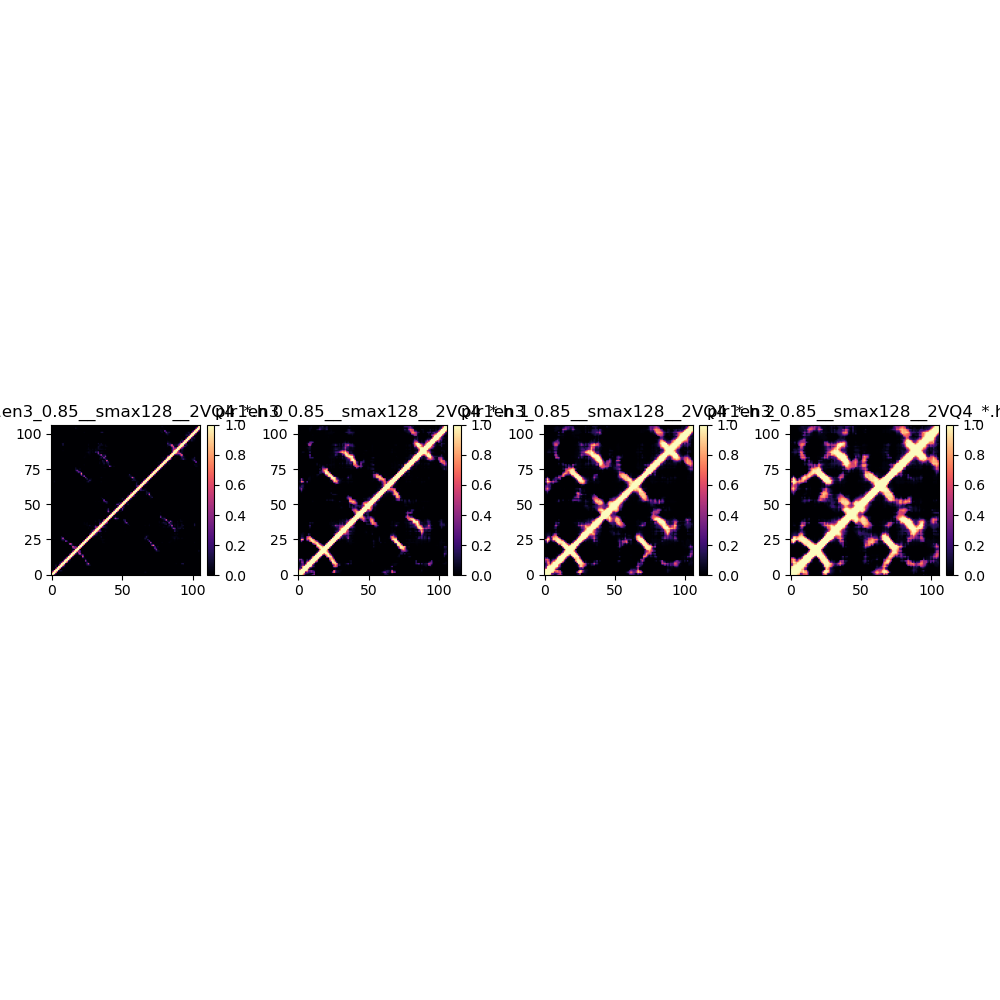

In [49]:
import matplotlib.pyplot as plt
import mplcursors  # Ensure mplcursors is installed
%matplotlib widget 

# Assuming contact_maps, visualize_map, and coordinate_list are defined
fig, axes = plt.subplots(1, len(contact_maps[0]), figsize=(10, 10))

for i in range(4):
    matrix, atomnum = visualize_map(contact_maps[-2][i], coordinate_list[i])
    im = axes[i].imshow(matrix, cmap='magma')
    axes[i].set_title(f"{cf[-32:-1]} {i}")
    axes[i].set_ylim(0, atomnum)
    fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.046, pad=0.04)

# Enable tight layout
fig.set_tight_layout(True)

# Add interactive annotation with mplcursors
for ax, i in zip(axes, range(4)):
    cursor = mplcursors.cursor(ax.images, hover=True)  # Enables clicking
    matrix, _ = visualize_map(contact_maps[-2][i], coordinate_list[i])  # Retrieve matrix for each plot

    # Display row, col, and matrix value
    cursor.connect("add", lambda sel, matrix=matrix: sel.annotation.set_text(
        f"Row: {int(sel.target[0])}, Col: {int(sel.target[1])}\nContact %: {matrix[int(sel.target[0]), int(sel.target[1])]*100:.2f}"
    ))

plt.show()


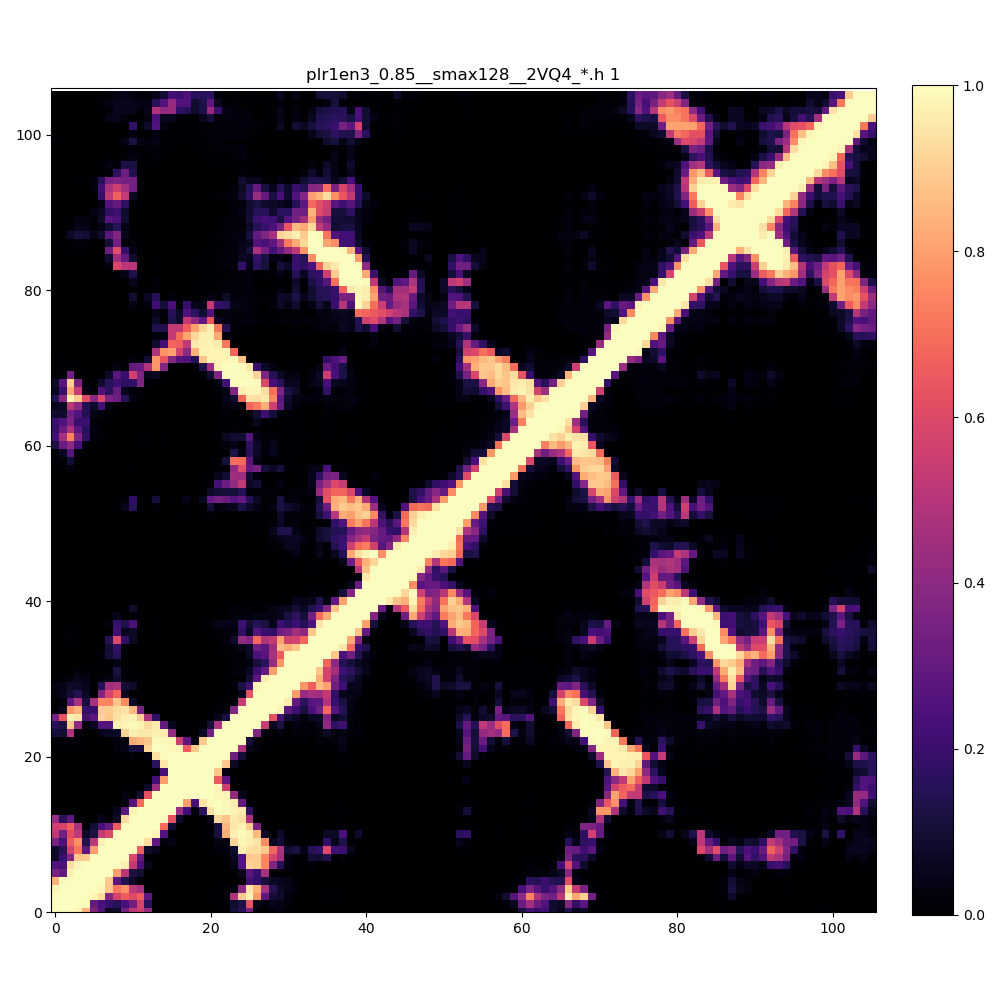

In [51]:
import matplotlib.pyplot as plt
import mplcursors  # Ensure mplcursors is installed
%matplotlib widget

# Assuming contact_maps, visualize_map, and coordinate_list are defined
fig, axes = plt.subplots(1,1, figsize=(10, 10))

matrix, atomnum = visualize_map(contact_maps[-2][2], coordinate_list[2])
im = axes.imshow(matrix, cmap='magma')
axes.set_title(f"{cf[-32:-1]} {1}")
axes.set_ylim(0, atomnum)
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.046, pad=0.04)

# Enable tight layout
fig.set_tight_layout(True)

# Add interactive annotation with mplcursors

cursor = mplcursors.cursor(axes.images, hover=False)  # Enables clicking
matrix, _ = visualize_map(contact_maps[-2][2], coordinate_list[2])  # Retrieve matrix for each plot

# Display row, col, and matrix value
cursor.connect("add", lambda sel, matrix=matrix: sel.annotation.set_text(
    f"Row: {int(sel.target[0])}, Col: {int(sel.target[1])}\nContact %: {matrix[int(sel.target[0]), int(sel.target[1])]*100:.2f}"
    ))

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import mplcursors  # For interactive annotations on the contact map
import nglview as nv  # For protein visualization
from ipywidgets import HBox  # To arrange plots side-by-side


# Set up globals to store selected atom positions
selected_row = None
selected_col = None
selected_value = None

# Load your protein structure file into NGLView
structure_file = "path/to/your/protein.pdb"  # Update with the path to your PDB file
view = nv.show_file(structure_file)
view.clear_representations()  # Clear default representation
view.add_representation("cartoon", color="spectrum")  # Set cartoon representation as the default

# Assuming contact_maps and visualize_map are defined
fig, axes = plt.subplots(1, len(contact_maps[0]), figsize=(50, 20))

# Function to highlight selected atoms in NGLView
def highlight_atoms(row, col):
    # Assuming `coordinate_list[row]` and `coordinate_list[col]` give atom IDs or positions
    atom1 = coordinate_list[row]
    atom2 = coordinate_list[col]

    # Clear previous highlights and add new ones
    view.clear_representations()
    view.add_representation("cartoon", color="spectrum")  # Base structure
    view.add_representation("ball+stick", selection=f"@{atom1} or @{atom2}", color="red")

for i in range(4):
    matrix, atomnum = visualize_map(contact_maps[-2][i], coordinate_list[i])
    im = axes[i].imshow(matrix, cmap='magma')
    axes[i].set_title(f"{cf[-32:-1]} {i}")
    axes[i].set_ylim(0, atomnum)
    fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.046, pad=0.04)

# Add interactive annotation with mplcursors
fig.set_tight_layout(True)
for ax, i in zip(axes, range(4)):
    cursor = mplcursors.cursor(ax.images, hover=False)  # Enables clicking
    matrix, _ = visualize_map(contact_maps[-2][i], coordinate_list[i])  # Retrieve matrix for each plot

    def on_click(sel, matrix=matrix):
        global selected_row, selected_col, selected_value
        selected_row = int(sel.target[0])
        selected_col = int(sel.target[1])
        selected_value = matrix[selected_row, selected_col]
        
        # Set annotation text
        sel.annotation.set_text(f"Row: {selected_row}, Col: {selected_col}\nValue: {selected_value:.2f}")
        
        # Highlight atoms in NGLView
        highlight_atoms(selected_row, selected_col)

    cursor.connect("add", on_click)

plt.show()

# Display side-by-side with NGLView
display(HBox([view, fig.canvas]))


In [ ]:
!pip install nglview